In [1]:
import sys
import matplotlib
%matplotlib inline
import argparse
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from notebooks.data_loader import load_data
from notebooks.helper_fxns import create_run_dir
from notebooks.print_n_plot import *
import warnings
import lasagne
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.regularization import regularize_network_params, l2
from lasagne.updates import *
from lasagne.init import HeNormal
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import *
import theano
from theano import tensor as T
import sys
import numpy as np
import logging
import time
import pickle
import argparse

importing Jupyter notebook from notebooks/data_loader.ipynb


Welcome to ROOTaaS 6.06/06
importing Jupyter notebook from notebooks/helper_fxns.ipynb
importing Jupyter notebook from notebooks/print_n_plot.ipynb


In [2]:
def get_cl_args():
    # if inside a notebook, then get rid of weird notebook arguments, so that arg parsing still works
    if any(["jupyter" in arg for arg in sys.argv]):
        sys.argv=sys.argv[:1]


    parser = argparse.ArgumentParser()

    parser.add_argument('-l', '--learn_rate', default=0.01, type=float,
        help='the learning rate for the network')

    parser.add_argument('-n', '--num_ims', default=2000, type=int,
        help='number of total images')

    parser.add_argument('-f', '--num_filters', default=128, type=int,
        help='number of filters in each conv layer')

    parser.add_argument('-e', '--num_epochs', default=5000, type=int)

    parser.add_argument('-b', '--batch_size', default=128, type=int)

    parser.add_argument( '--fc', default=1024, type=int,
        help='number of fully connected units')


    args = parser.parse_args()
    return args

In [3]:
def build_network(args, network):
    X = T.tensor4('input_var')
    Y = T.ivector('target_var')
    #network = build_layers(args)
    '''write loss function equation'''
    prediction = get_output(network, X)
    loss = categorical_crossentropy(prediction, Y).mean()
    weightsl2 = regularize_network_params(network, l2)
    loss += args['weight_decay'] * weightsl2
    
    '''calculate test loss (cross entropy with no regularization) and accuracy'''
    test_prediction = get_output(network, X, deterministic=True)
    test_loss = categorical_crossentropy(test_prediction, Y).mean()
    
    '''classification percentage: we can change this based on false postive/false negative criteria'''
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), Y))
    params = get_all_params(network, trainable=True)
    #new_weight += momentum*prev_step  - leaarning_rate * (dL(cur_weight + momentum*prev_step)/dcur_weight) 
    updates = nesterov_momentum(loss, params, learning_rate=args['learning_rate'], momentum=args['momentum'])
    '''train_fn -> takes in input,label pairs -> outputs loss '''
    train_fn = theano.function([X, Y], loss, updates=updates)
    '''val_fn -> takes in input,label pairs -> outputs non regularized loss and accuracy '''
    val_fn = theano.function([X, Y], [test_loss, test_acc])
    out_fn = theano.function([X], [test_prediction])
    return {
            'tr_fn': train_fn, 
            'val_fn': val_fn, 
            'network': network,
            'out_fn': out_fn
            
            }

def build_layers(args):
    
    conv_kwargs = dict(num_filters=args['num_filters'], filter_size=3, pad=1, nonlinearity=relu, W=HeNormal())
    network = InputLayer(shape=args['input_shape'])
    for lay in range(args['num_layers']):
        network = batch_norm(Conv2DLayer(network, **conv_kwargs))
        network = MaxPool2DLayer(network, pool_size=(2,2),stride=2)
    network = dropout(network, p=args['dropout_p'])
    network = DenseLayer(network,num_units=args['num_fc_units'], nonlinearity=relu) 
    network = dropout(network, p=args['dropout_p'])
    network = DenseLayer(network, num_units=2, nonlinearity=softmax)
    
    for layer in get_all_layers(network):
        logger.info(str(layer) + str(layer.output_shape))
    print count_params(layer)
    
    return network

In [4]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    if batchsize > inputs.shape[0]:
        batchsize=inputs.shape[0]
    for start_idx in range(0,len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx: start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [5]:
def shuffle(x,y):
    inds = np.arange(x.shape[0])

    #shuffle data
    rng = np.random.RandomState(7)
    rng.shuffle(inds)
    return x[inds], y[inds]

def split_train_val(x,y):
    inds = np.arange(x.shape[0])
    #split train, val, test
    tr_inds = inds[:int(0.8*len(inds))] 
    val_inds = inds[int(0.8*len(inds)):]

    x_tr, y_tr, x_val, y_val = x[tr_inds], y[tr_inds], x[val_inds], y[val_inds]
    return x_tr, y_tr, x_val, y_val



def preprocess(x, max_abs=None):
    '''a type of sparse preprocessing, which scales everything between -1 and 1 without losing sparsity'''
    #only calculate the statistic using training set
    if max_abs is None:
        max_abs=np.abs(x).max(axis=(0,1,2,3))

    #then scale all sets
    x /= max_abs
    print np.max(x)
    print np.min(x)
    return x, max_abs




In [6]:
def load_train_val(num_events=1000,bin_size=0.1):
    x, y = load_data(num_events=num_events, bin_size=bin_size)
    x_tr, y_tr, x_val, y_val  = split_train_val(*shuffle(x,y))
    x_tr, max_abs = preprocess(x_tr)
    x_val, _ = preprocess(x_val, max_abs)
    return x_tr, y_tr, x_val, y_val

def load_test(num_events=None):
    x,y = load_data(bg_cfg_file='./config/TestSetBgFileListAug16.txt', 
                    sig_cfg_file='./config/TestSetSignalFileListAug16.txt',
                    num_events=num_events, 
                    bin_size=0.1)
    x_te, y_te = shuffle(x,y)
    x_te = preprocess(x_te)
    return x_te, y_te

In [7]:
def get_logger(run_dir):
    logger = logging.getLogger('log_train')
    if not getattr(logger, 'handler_set', None):
        logger.setLevel(logging.INFO)
        fh = logging.FileHandler('%s/training.log'%(run_dir))
        fh.setLevel(logging.INFO)
        ch = logging.StreamHandler()
        ch.setLevel(logging.INFO)
        logger.addHandler(ch)
        logger.addHandler(fh)
    return logger

In [8]:
def train_val(net_cfg, network_kwargs, data, logger, run_dir):


    x_tr, y_tr, x_val, y_val = data
    logger.info("training set size: %i, val set size %i " %( x_tr.shape[0], x_val.shape[0]))

    tr_losses = []
    val_losses = []
    val_accs = []
    tr_accs = []
    for epoch in range(network_kwargs['num_epochs']):

        start = time.time() 
        tr_loss = 0
        tr_acc = 0
        for iteration, (x, y) in enumerate(iterate_minibatches(x_tr,y_tr, batchsize=network_kwargs['batch_size'])):
            #x = np.squeeze(x)
            loss = net_cfg['tr_fn'](x, y)
            weights = sum([np.sum(a.eval()) for a in get_all_params(net_cfg['network']) if str(a) == 'W'])
            #logger.info("weights : %6.3f" %(weights))
            #logger.info("x avg : %5.5f shape: %s : iter: %i  loss : %6.3f " % (np.mean(x), str(x.shape), iteration, loss))
            _, acc = net_cfg['val_fn'](x,y)
            logger.info("iteration % i train loss is %f"% (iteration, loss))
            logger.info("iteration % i train acc is %f"% (iteration, acc))
            tr_acc += acc
            tr_loss += loss

        train_end = time.time()
        tr_avgacc = tr_acc / (iteration + 1)
        tr_avgloss = tr_loss / (iteration + 1)


        logger.info("train time : %5.2f seconds" % (train_end - start))
        logger.info("  epoch %i of %i train loss is %f" % (epoch, num_epochs, tr_avgloss))
        logger.info("  epoch %i of %i train acc is %f percent" % (epoch, num_epochs, tr_avgacc * 100))
        tr_losses.append(tr_avgloss)
        tr_accs.append(tr_avgacc)

        val_loss = 0
        val_acc = 0
        for iteration, (xval, yval) in enumerate(iterate_minibatches(x_val,y_val, batchsize=network_kwargs['batch_size'])):
            #xval = np.squeeze(xval)
            loss, acc = net_cfg['val_fn'](xval, yval)
            val_loss += loss
            val_acc += acc

        val_avgloss = val_loss / (iteration + 1)
        val_avgacc = val_acc / (iteration + 1)

        logger.info("val time : %5.2f seconds" % (time.time() - train_end))
        logger.info("  epoch %i of %i val loss is %f" % (epoch, num_epochs, val_avgloss))
        logger.info("  epoch %i of %i val acc is %f percent" % (epoch, num_epochs, val_avgacc * 100))

        val_losses.append(val_avgloss)
        val_accs.append(val_avgacc)

        plot_learn_curve(tr_losses, val_losses, save_dir=run_dir)
        plot_learn_curve(tr_accs, val_accs, save_dir=run_dir, name="acc")
        pickle.dump(net_cfg['network'],open(run_dir + "/model.pkl", 'w'))

    #     if epoch % 5 == 0:
    #         plot_filters(net_cfg['network'], save_dir=run_dir)
    #         for iteration, (xval, yval) in enumerate(iterate_minibatches(x_val,y_val, batchsize=batchsize)):
    #             plot_feature_maps(iteration, xval,net_cfg['network'], save_dir=run_dir)
    #             break;

In [9]:
def plot_example(x):
    plt.imshow(np.log10(x).T,extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low')
    plt.colorbar()

In [73]:
def plot_examples(x, dim, run_dir='.', name='ims'):
    plt.clf()
    assert x.shape[0] == dim**2, "not the right number examples images"
    fig, axes = plt.subplots(nrows=dim, ncols=dim, figsize=(40,40))
    for ex, ax in zip(x, axes.flat):
        im = ax.imshow(np.log10(ex).T,extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low', vmin=-10, vmax=0)

    #cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    #fig.colorbar(im, cax=cax)
    #plt.show()
    plt.savefig(run_dir + '/' + name + ".png")
        

In [81]:
def plot_filters(network,num_channels_to_plot = 16, save_dir='.'):
    plt.figure(figsize=(30,30))
    plt.clf()
    lay_ind = 0
    convlayers = [layer for layer in get_all_layers(network) if isinstance(layer, Conv2DLayer)]
    num_layers = len(convlayers)
    spind = 1 
    for i,layer in enumerate(convlayers):
        filters = layer.get_params()[0].eval()
        if i==0:
            filt = filters
        else:
            filt= filters[0]
        for ch_ind in range(num_channels_to_plot):
            p1 = plt.subplot(num_layers,num_channels_to_plot, spind )
            p1.imshow(filt[ch_ind], cmap="gray")
            spind = spind + 1
    
    #plt.show()
    plt.savefig(save_dir +'/filters.png')
            

In [93]:
def plot_feature_maps(im, network, save_dir='.', name=""):
    plt.figure(figsize=(30,30))
    plt.clf()
    convlayers = [layer for layer in get_all_layers(network) if isinstance(layer,Conv2DLayer) or isinstance(layer,Pool2DLayer)]
    num_layers = len(convlayers)
    spind = 1 
    num_fmaps_to_plot = 16
    print im.shape
    for ch in range(num_fmaps_to_plot):
        p1 = plt.subplot(num_layers + 1,num_fmaps_to_plot, spind )
        p1.imshow(np.log10(im.T))
        spind = spind + 1
    
    # take im from 2d to 4d so the network likes it
    x=np.expand_dims(np.expand_dims(im, axis=0), axis=0)
    for layer in convlayers:
        # shape is batch_size, num_filters, x,y 
        fmaps = get_output(layer,x ).eval()
        print fmaps.shape
        for fmap_ind in range(num_fmaps_to_plot):
            p1 = plt.subplot(num_layers + 1,num_fmaps_to_plot, spind )
            p1.imshow(fmaps[0][fmap_ind].T)
            spind = spind + 1
    
    #plt.show()
    plt.savefig(save_dir +'/fmaps_%s.png' %(name))

In [90]:
np.expand_dims(np.expand_dims(np.zeros((20,20)), axis=0), axis=0).shape

(1, 1, 20, 20)


variable "np" not defined.

variable "np.ex" not defined.

variable "np" not defined.

variable "np.expand_" not defined.


In [69]:
plt.subplots?


variable "plt" not defined.

variable "plt.sun" not defined.

variable "plt" not defined.

variable "plt.sub" not defined.


In [10]:
def test_network(network_path):
    x_te, y_te = load_test()

    net = pickle.load(open(network_path))

    cfg = build_network(network_kwargs,net)
    return cfg['val_fn'](x_te, y_te)

In [11]:
if __name__ == "__main__":
    args = get_cl_args()


    run_dir = create_run_dir()
    logger = get_logger(run_dir)
    data = load_train_val(args.num_ims)
    network_kwargs = {'input_shape':tuple([None] + [data[0].shape[i] for i in [1,2,3]]), 
                      'learning_rate': args.learn_rate, 
                      'dropout_p': 0, 
                      'weight_decay': 0.0001, 
                      'num_filters': args.num_filters, 
                      'num_fc_units': args.fc,
                      'num_layers': 4,
                      'momentum': 0.9,
                      'num_epochs': args.num_epochs,
                      'batch_size': args.batch_size}
    logger.info(str(network_kwargs))
    net_cfg = build_network(network_kwargs, build_layers(network_kwargs))
    train_val(net_cfg, network_kwargs, data, logger, run_dir)
    
    
    

/global/homes/w/wbhimji/cori-envs/nersc-rootpy/lib/python2.7/site-packages/root_numpy/_tree.py:209: RuntimeWarning: tree 'CollectionTree' not found in /global/projecta/projectdirs/atlas/atlaslocalgroupdisk/rucio/mc15_13TeV/14/bb/DAOD_EXOT3.08597479._000007.pool.root.1
  warn_missing_tree)
{'num_epochs': 5000, 'dropout_p': 0, 'momentum': 0.9, 'num_filters': 128, 'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'num_layers': 4, 'input_shape': (None, 1, 62, 100), 'num_fc_units': 1024}
<lasagne.layers.input.InputLayer object at 0x2b2c7423df10>(None, 1, 62, 100)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2ca13b2450>(None, 128, 62, 100)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2ca13a3c50>(None, 128, 62, 100)
<lasagne.layers.special.NonlinearityLayer object at 0x2b2ca13f4cd0>(None, 128, 62, 100)
<lasagne.layers.pool.MaxPool2DLayer object at 0x2b2ca13f4e10>(None, 128, 31, 50)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2ca13f4e50>(None, 128, 31, 50)
<l

1.0
-0.000960145564531
0.927595539232
-0.000706964282683
2807938
Traceback (most recent call last):
  File "/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/global/common/cori/software/python/2.7-

IndexError: string index out of range

INFO:log_train:{'num_epochs': 5000, 'dropout_p': 0, 'momentum': 0.9, 'num_filters': 128, 'batch_size': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'num_layers': 4, 'input_shape': (None, 1, 62, 100), 'num_fc_units': 1024}
INFO:log_train:<lasagne.layers.input.InputLayer object at 0x2b2c7423df10>(None, 1, 62, 100)
INFO:log_train:<lasagne.layers.conv.Conv2DLayer object at 0x2b2ca13b2450>(None, 128, 62, 100)
INFO:log_train:<lasagne.layers.normalization.BatchNormLayer object at 0x2b2ca13a3c50>(None, 128, 62, 100)
INFO:log_train:<lasagne.layers.special.NonlinearityLayer object at 0x2b2ca13f4cd0>(None, 128, 62, 100)
INFO:log_train:<lasagne.layers.pool.MaxPool2DLayer object at 0x2b2ca13f4e10>(None, 128, 31, 50)
INFO:log_train:<lasagne.layers.conv.Conv2DLayer object at 0x2b2ca13f4e50>(None, 128, 31, 50)
INFO:log_train:<lasagne.layers.normalization.BatchNormLayer object at 0x2b2ca13f4fd0>(None, 128, 31, 50)
INFO:log_train:<lasagne.layers.special.NonlinearityLayer object at 0x2b2ca13dd450>

In [12]:
#test
x, y, xv,yv = load_train_val(num_events=100000)

1.0
-0.00100618216482
1.0479475217
-0.000693142496177


In [13]:
network_path = './results/run84/model.pkl'

(200, 1, 62, 100)

In [15]:
net = pickle.load(open(network_path))

cfg = build_network(network_kwargs,net)

INFO (theano.gof.compilelock): Refreshing lock /global/u1/r/racah/.theano/compiledir_Linux-3.12--default-x86_64-with-SuSE-12-x86_64-x86_64-2.7.12-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /global/u1/r/racah/.theano/compiledir_Linux-3.12--default-x86_64-with-SuSE-12-x86_64-x86_64-2.7.12-64/lock_dir/lock


In [16]:
y_pred = cfg['out_fn'](xv)

In [17]:
y_pred = y_pred[0]

In [18]:
best_sig = xv[np.argmax(y_pred[:,1])]

In [19]:
best_bg = xv[np.argmin(y_pred[:,1])]

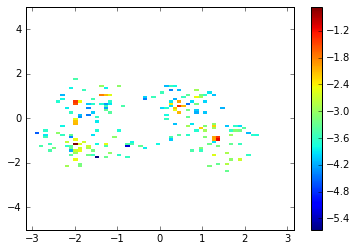

In [20]:
plot_example(np.squeeze(best_sig))

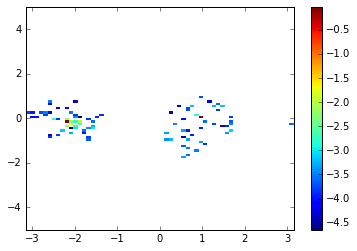

In [21]:
plot_example(np.squeeze(best_bg))

In [24]:
inds = np.argsort(y_pred[:,1], axis=0)

In [34]:
best_bgs = np.squeeze(xv[inds[:25]])

In [35]:
best_sigs = np.squeeze(xv[inds[-26:-1]])

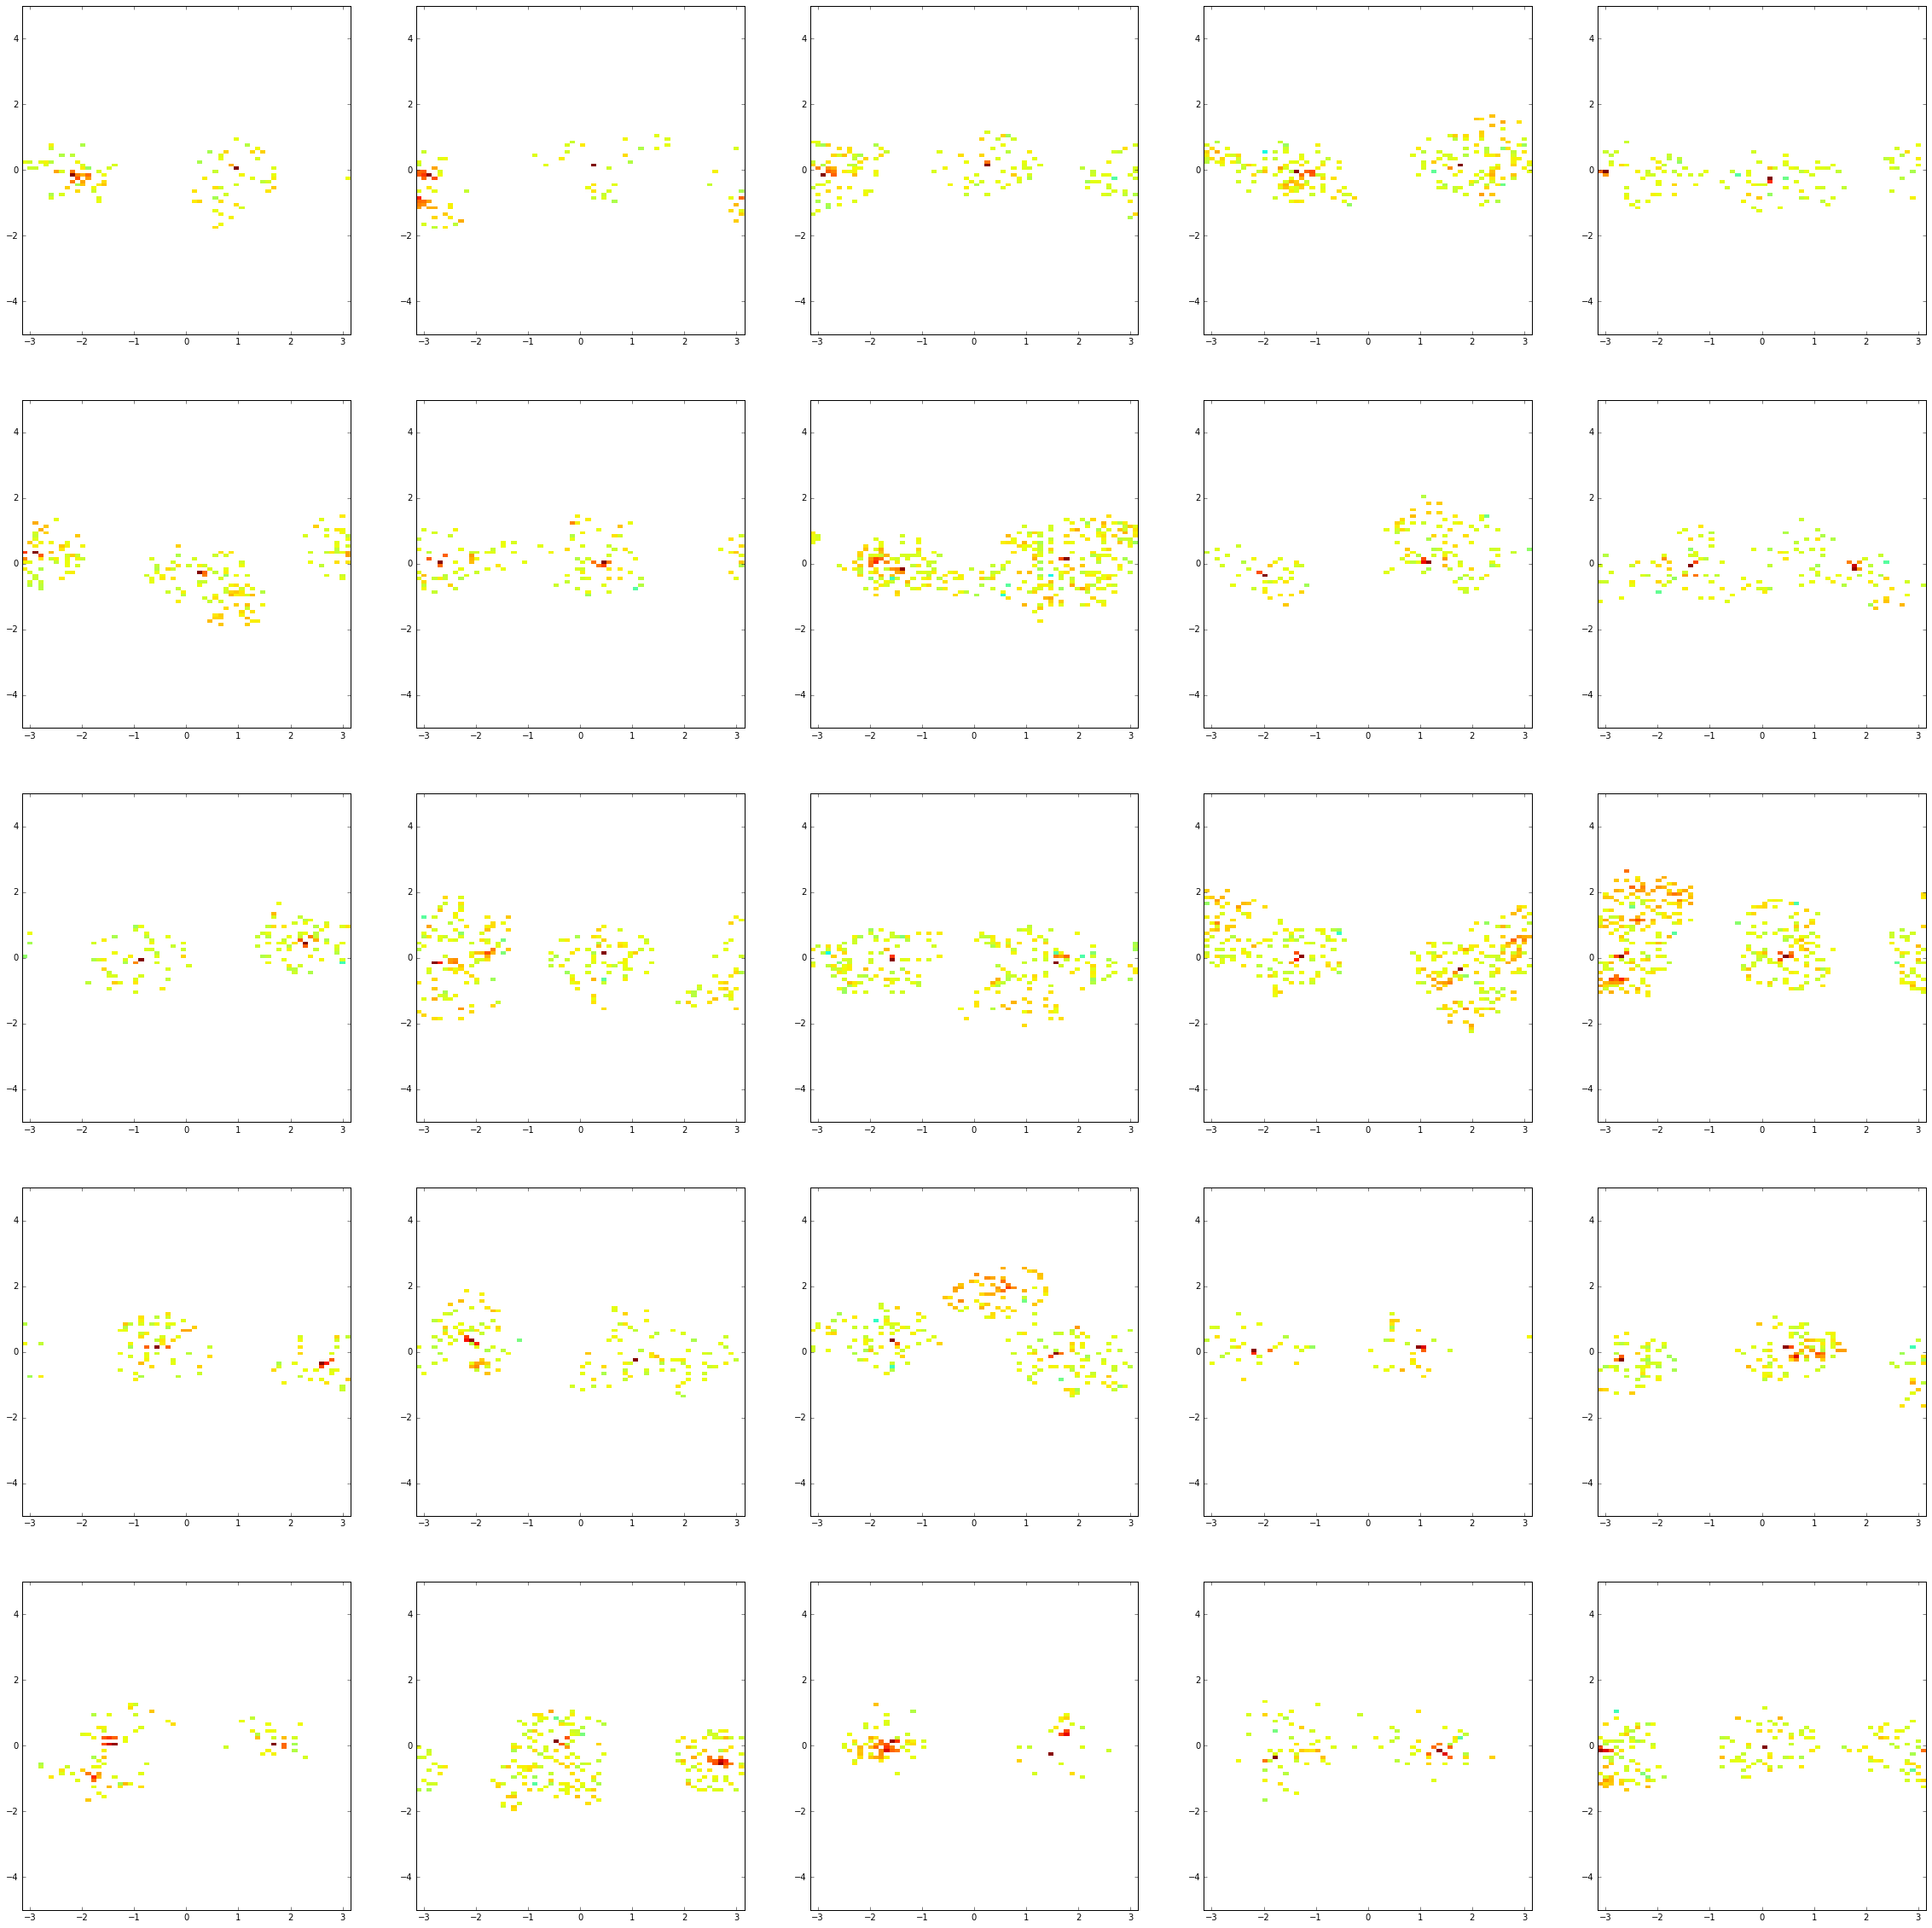

In [74]:
plot_examples(best_bgs,5, run_dir,"best_bg")

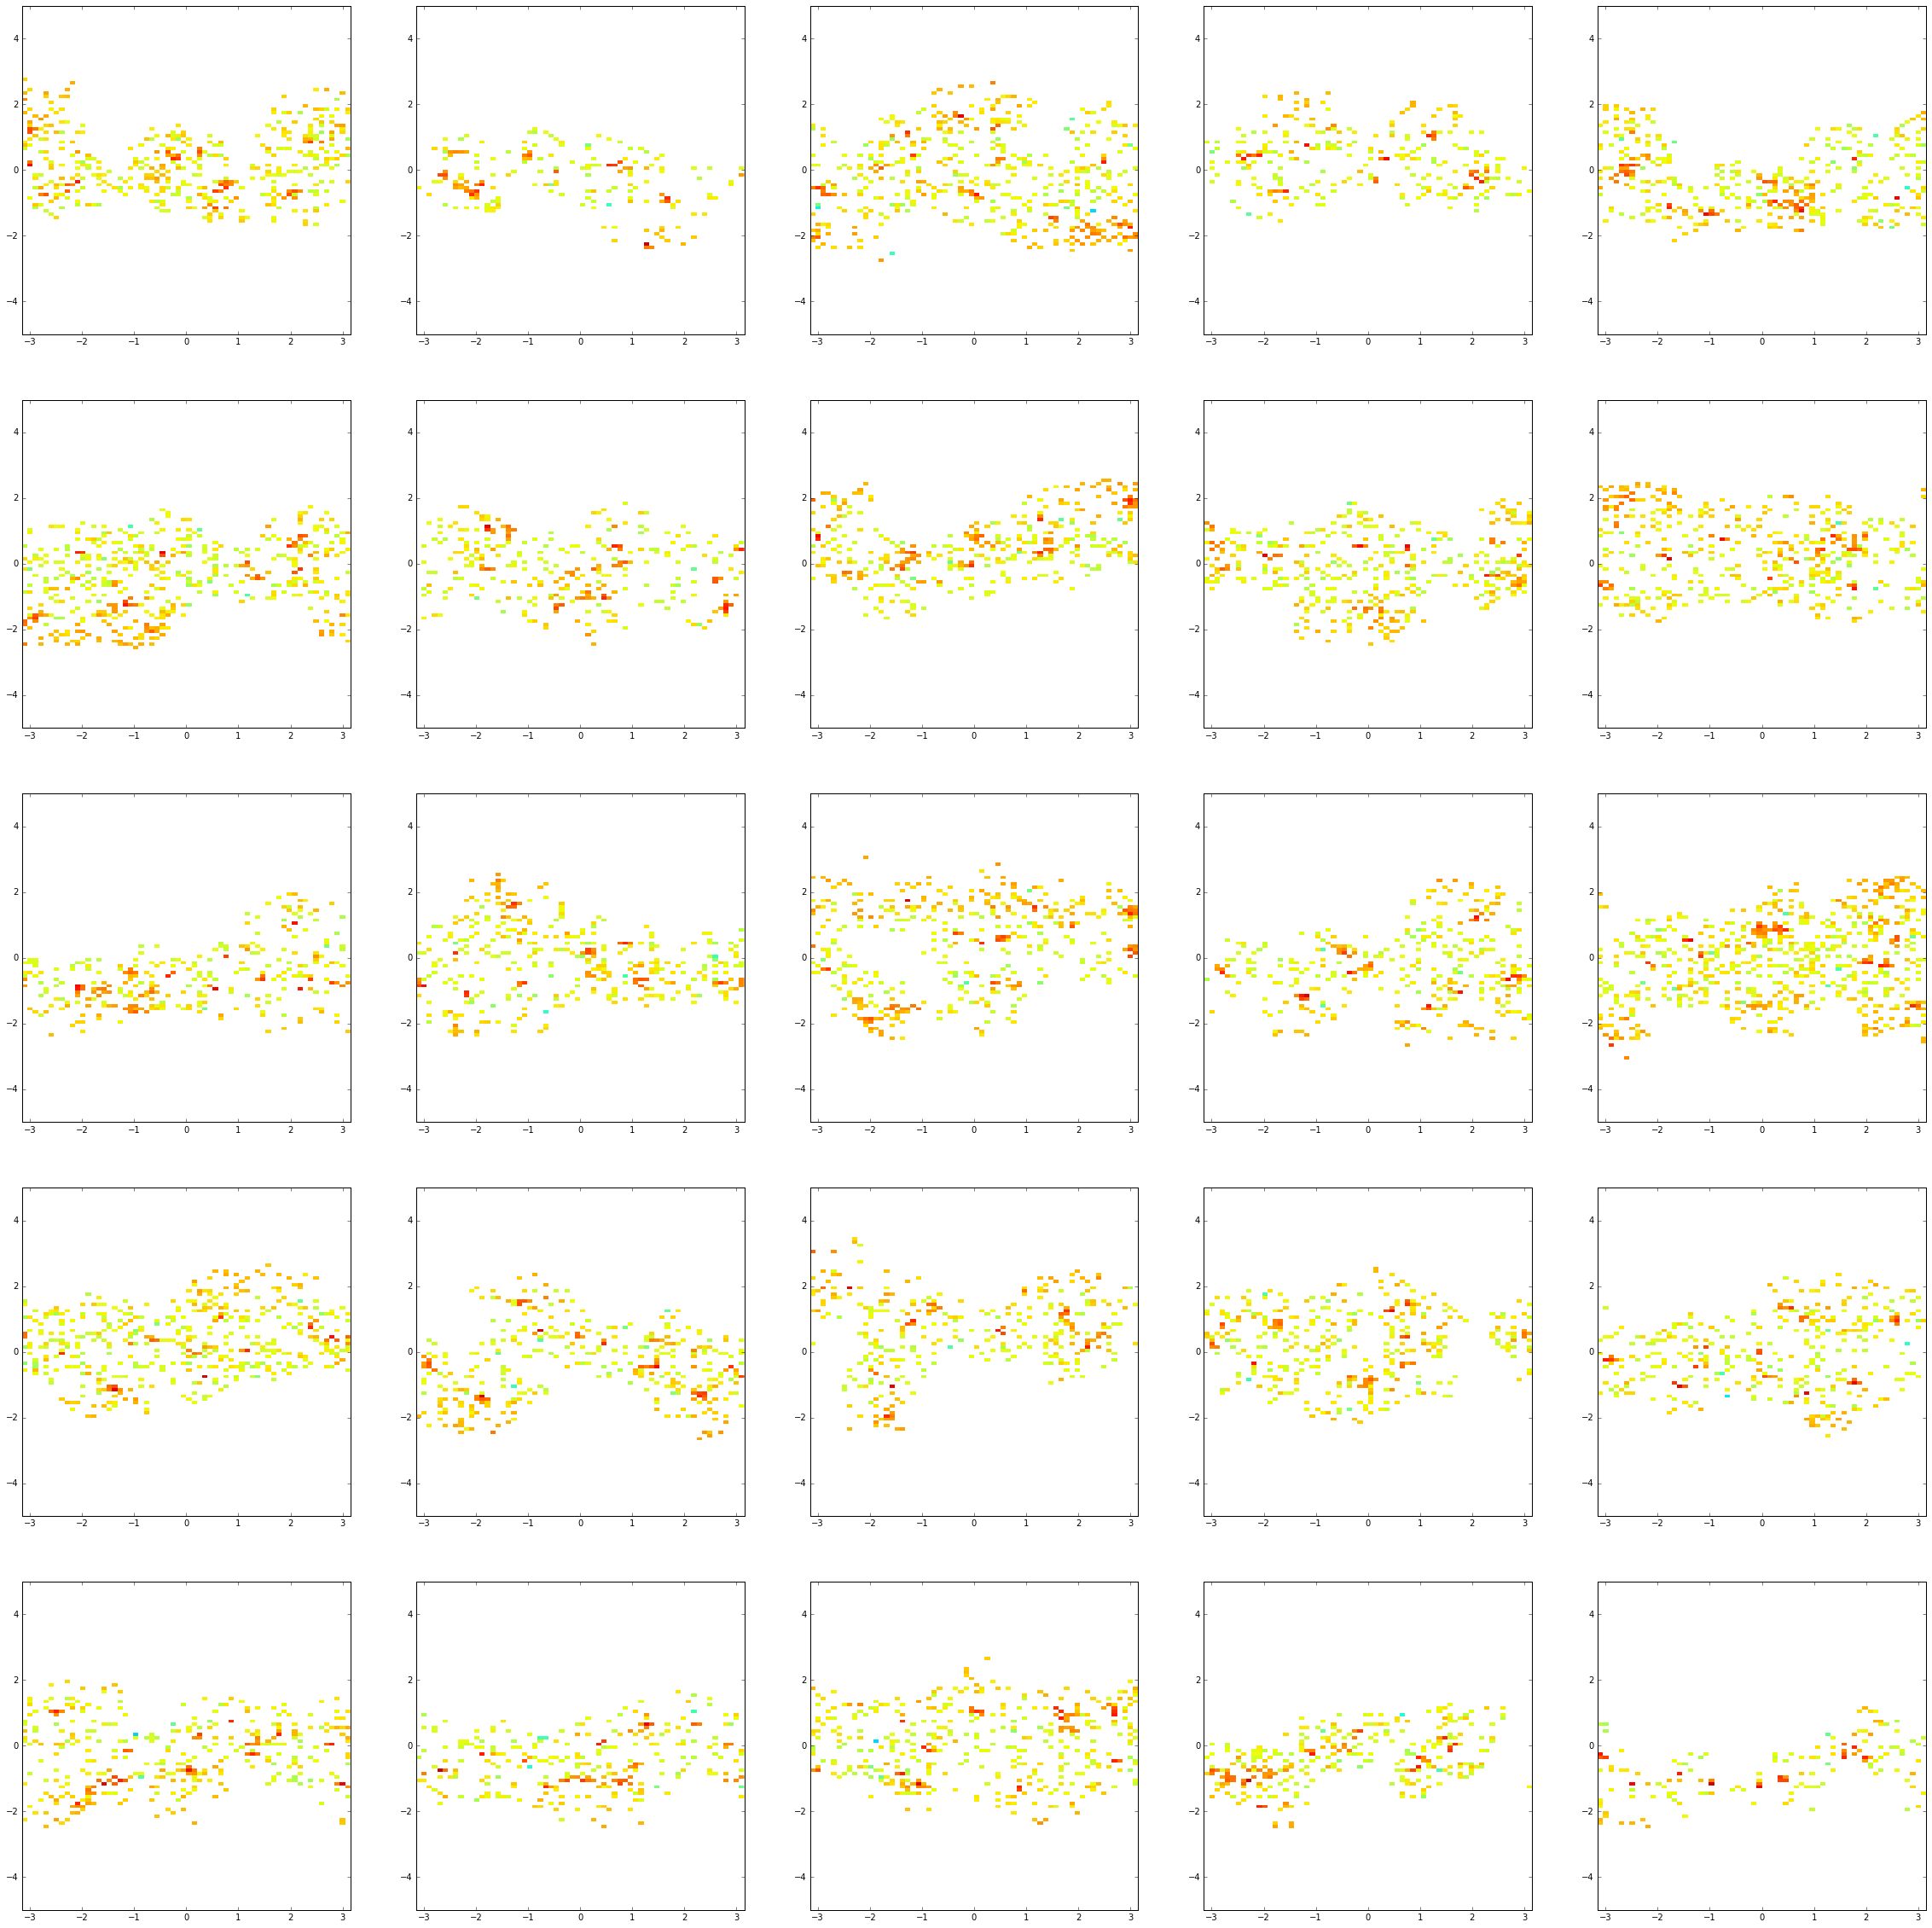

In [75]:
plot_examples(best_sigs,5, run_dir, "best_sig")

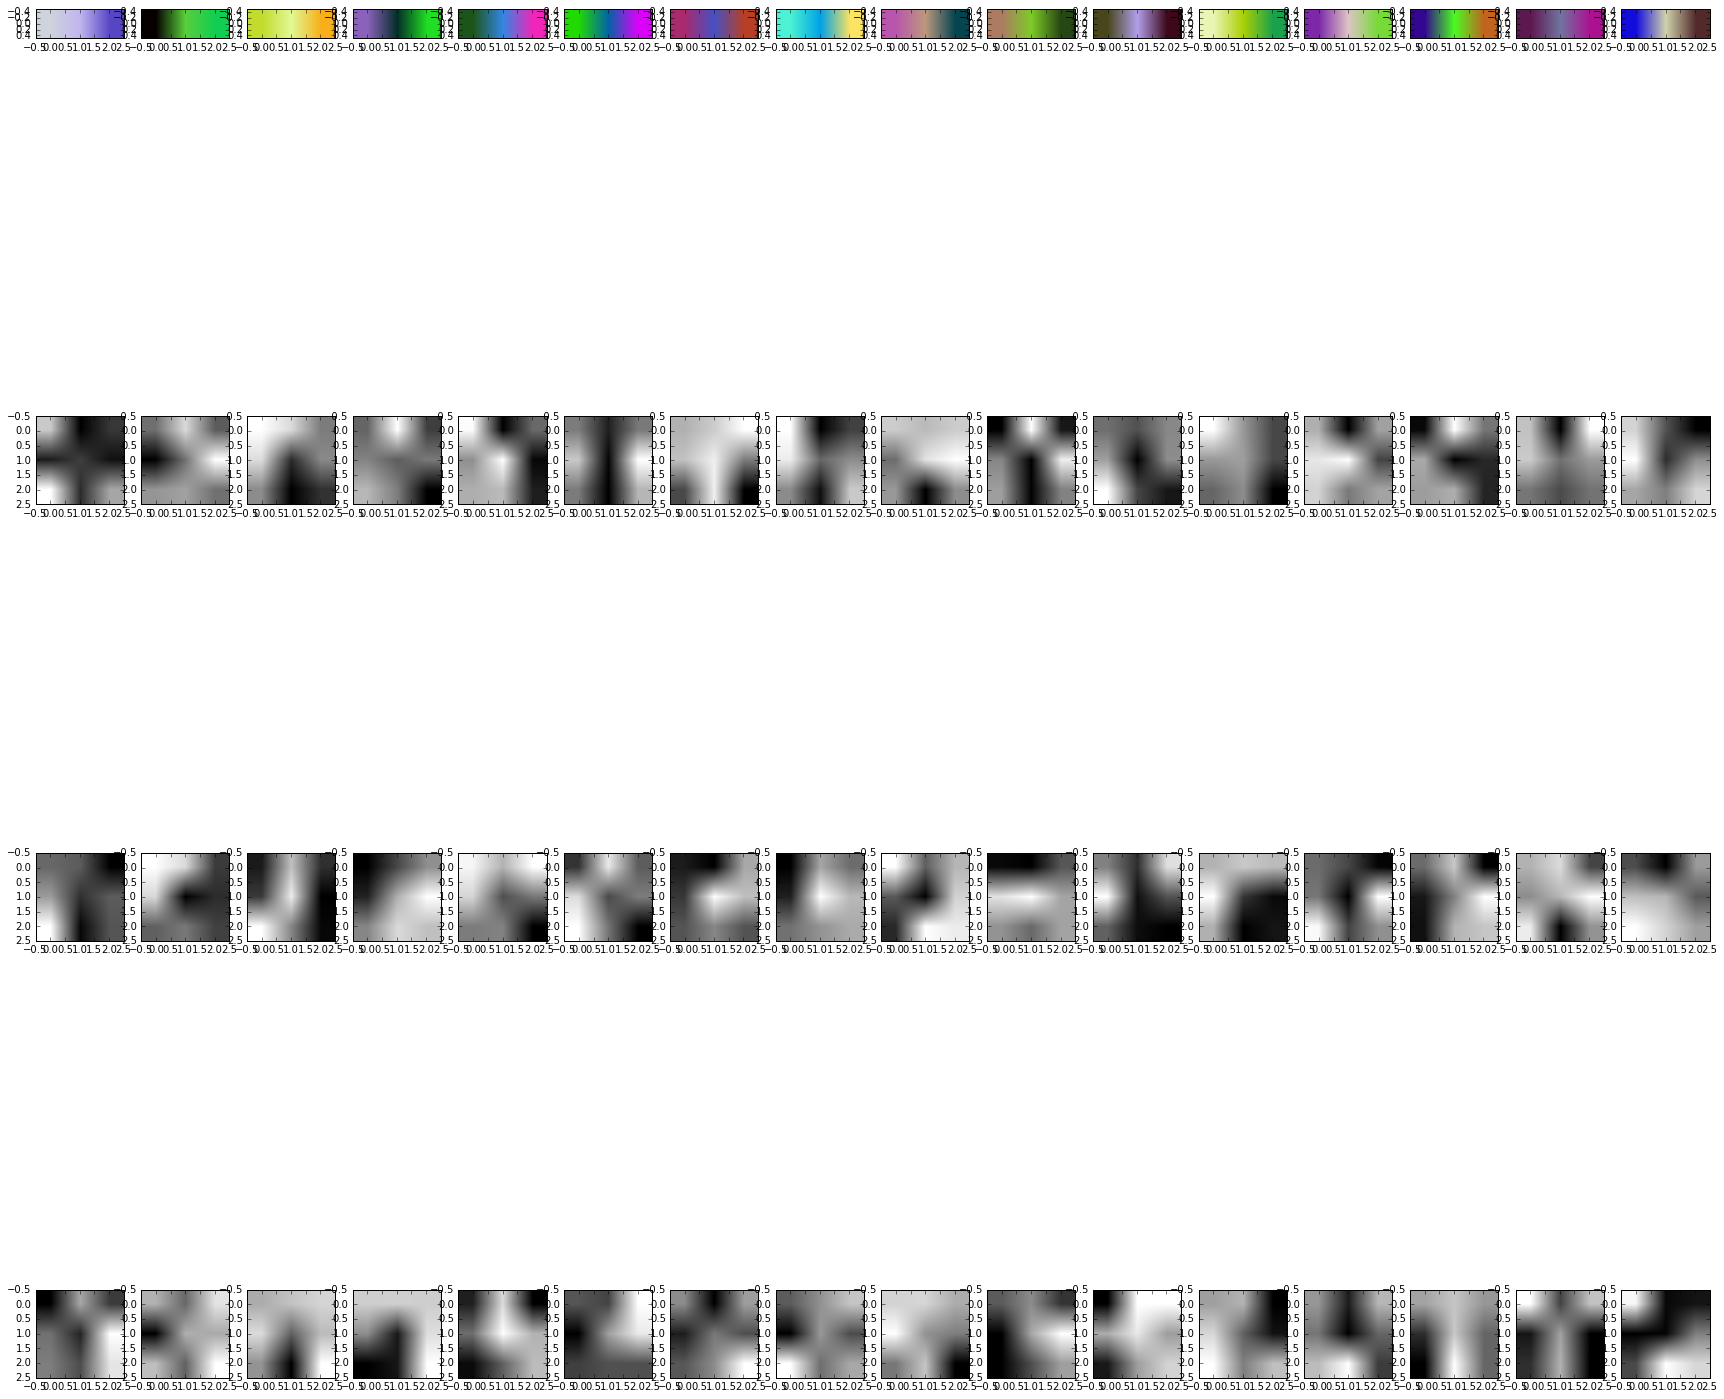

In [82]:
plot_filters(net,save_dir=run_dir)

(62, 100)


INFO (theano.gof.compilelock): Refreshing lock /global/u1/r/racah/.theano/compiledir_Linux-3.12--default-x86_64-with-SuSE-12-x86_64-x86_64-2.7.12-64/lock_dir/lock


(1, 128, 62, 100)
(1, 128, 31, 50)
(1, 128, 31, 50)
(1, 128, 15, 25)
(1, 128, 15, 25)
(1, 128, 7, 12)
(1, 128, 7, 12)
(1, 128, 3, 6)


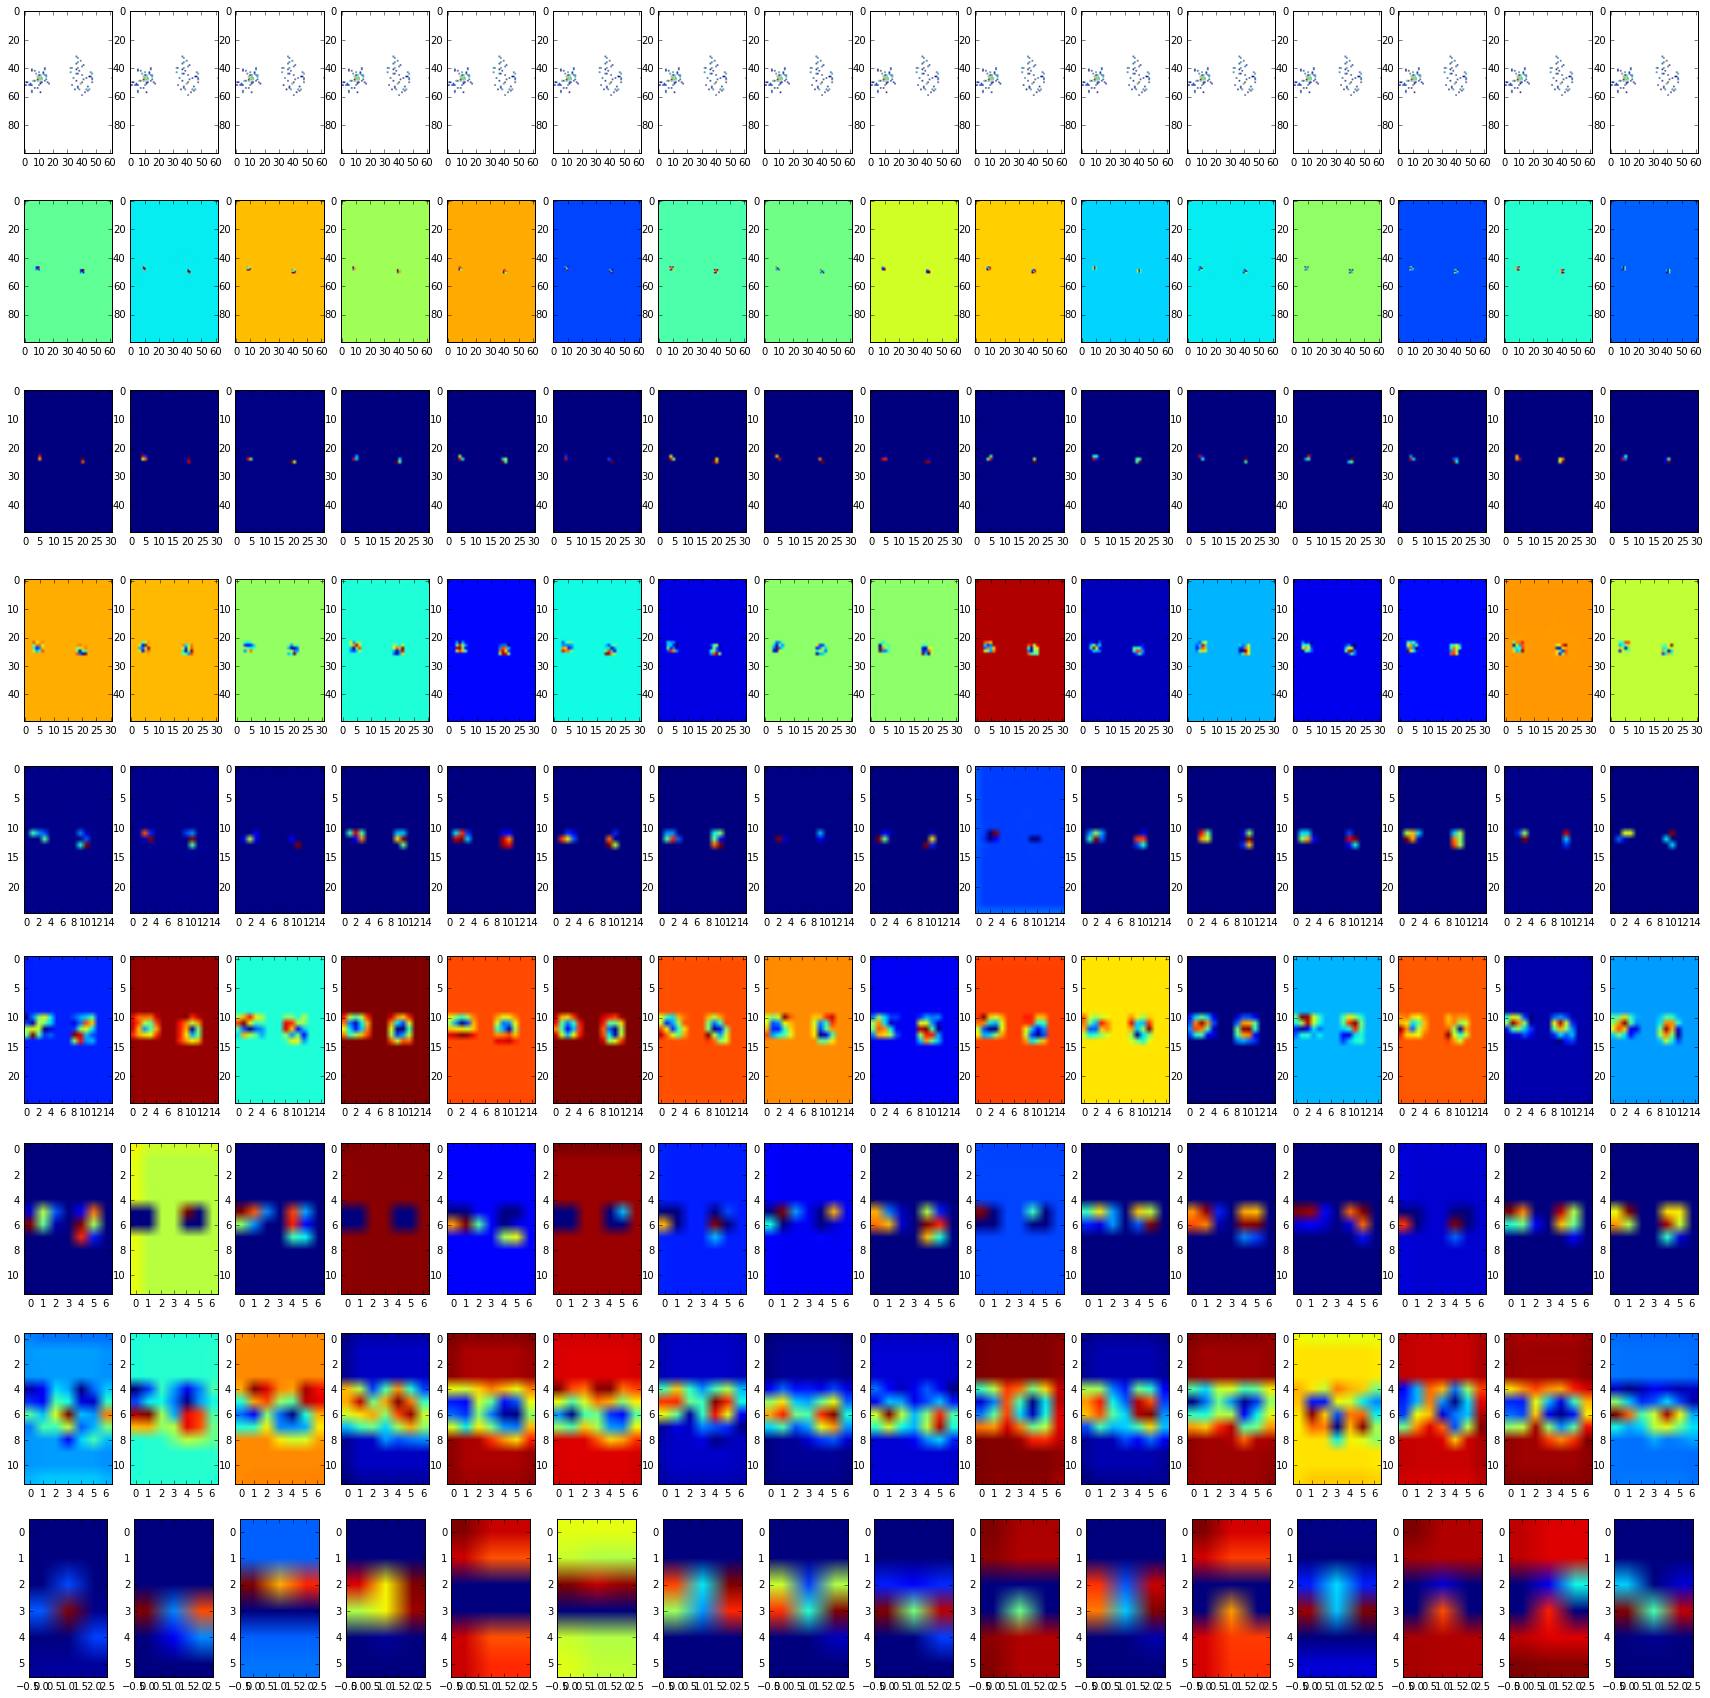

INFO:theano.gof.compilelock:Refreshing lock /global/u1/r/racah/.theano/compiledir_Linux-3.12--default-x86_64-with-SuSE-12-x86_64-x86_64-2.7.12-64/lock_dir/lock


In [95]:
plot_feature_maps(best_bgs[0], net, run_dir, name="best_bg")

In [99]:
import theano
import theano.tensor as T

def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = T.tensor4('inp')
    outp = lasagne.layers.get_output(net,inp, deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

In [100]:
classes = ['bg', 'sig']

In [139]:
def show_images(img_original, saliency, max_class, title, save_dir='.'):
    # get out the first map and class from the mini-batch
    saliency = saliency[0]
    max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    # plot the original image and the three saliency map variants
    im_args = dict(extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low')
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.suptitle("Class: " + classes[max_class] + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.log10(img_original).T, **im_args)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.squeeze(np.abs(saliency)).T, cmap='gray', **im_args)
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow(np.squeeze((np.maximum(0, saliency) / saliency.max())).T, **im_args)
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow(np.squeeze((np.maximum(0, -saliency) / -saliency.min())).T, **im_args)
    plt.savefig(run_dir + '/saliency_' + classes[max_class] + ".png" )
    plt.show()

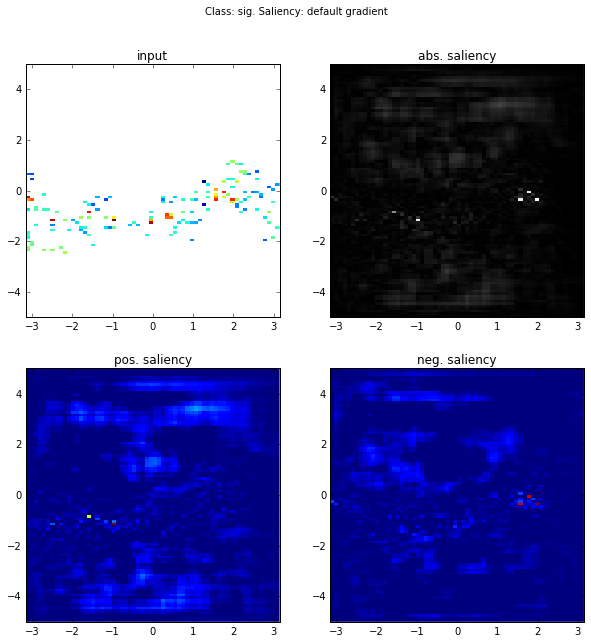

In [140]:
best_bg = np.expand_dims(np.expand_dims(best_bgs[0], axis=0),axis=0)
best_sig = np.expand_dims(np.expand_dims(best_sigs[-1], axis=0),axis=0)
saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(best_sig)
#np.squeeze(np.abs(saliency)).shape
show_images(best_sigs[-1], saliency, max_class, "default gradient", save_dir=run_dir)